In [196]:
import numpy as np
from matplotlib import pyplot as plt
import json, os

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [197]:
runs = np.arange(1, 4, 1)
k_g=1
a=50
b=90
d=1
rhoseed=0.4

pdir = '../../data/model_B_rho/k_g_{:1.3f}_rhoseed_{:1.3f}/a_{:1.3f}_b_{:1.3f}_d_{:1.3f}/run_{:d}/'.format(k_g, rhoseed, a, b, d, runs[-1])

datadir = pdir+'data/'

with open(pdir+'parameters.json') as jsonFile:
    parameters = json.load(jsonFile)

T         = parameters["T"]        # final time
dt_dump   = parameters["dt_dump"]
n_steps   = int(parameters["n_steps"])  # number of time steps
n_dump    = int(T/dt_dump); dn_dump = int(n_steps/n_dump)
d         = parameters["d"]; print("d =",d)
mx        = np.int32(parameters["mx"])
my        = np.int32(parameters["my"])
dx        = np.float32(parameters["dx"])
dy        = np.float32(parameters["dy"])
#setup a meshgrid
tol = 0.001

x   = np.linspace(0+tol, 1-tol, mx)
y   = np.linspace(0+tol, 1-tol, my)
xv, yv  = np.meshgrid(x,y)


times = np.arange(0, n_dump, 1)*dt_dump
print("n_dump =", n_dump)

d = 1.0
n_dump = 2000


0.6508817902138359 0.34370562621599665
0.42051663846361126


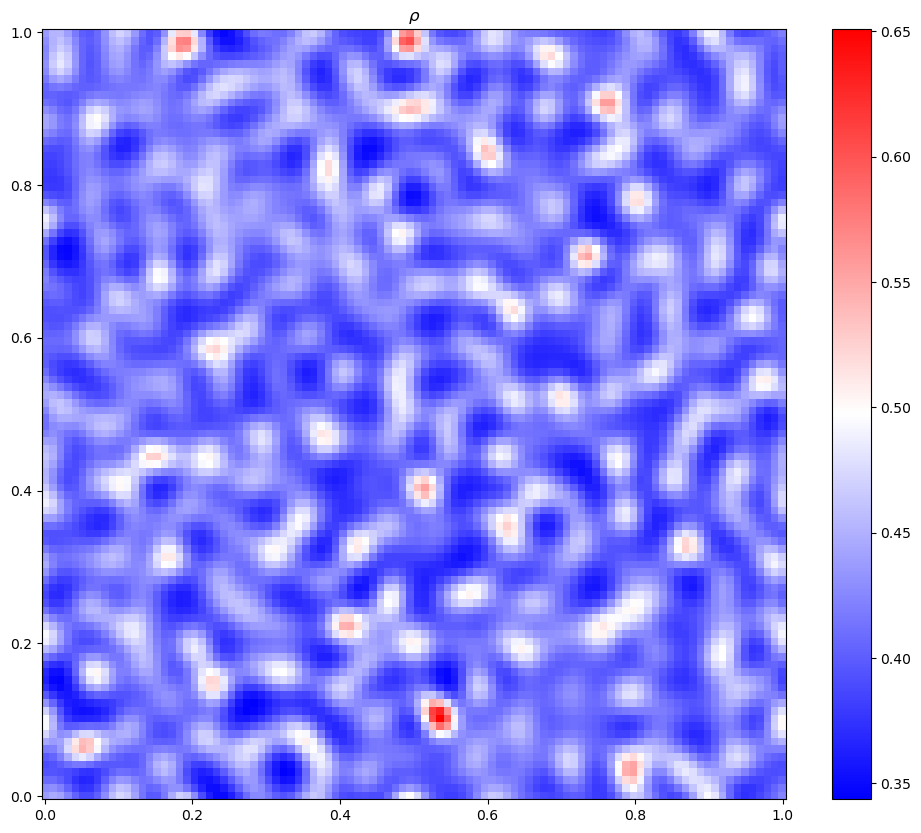

In [222]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

fig, ax=plt.subplots(figsize=(12,10))
#colors = ['#c1272d', '#eecc16','#008176','#0000a7']
#cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)
n=50#50

field = np.loadtxt(datadir+'rho.csv.{:d}'.format(n), delimiter=',')
fmax = np.max(field); fmin=np.min(field); print(fmax, fmin)
print(np.average(field))
ctrf = [ax.pcolormesh(xv, yv, field, vmin=fmin, vmax=fmax, cmap='bwr')]
plt.colorbar(ctrf[0])
plt.title(r"$\rho$")
plt.show()

In [199]:
#q = np.fft.fftfreq(mx)
q2 = np.fft.rfftfreq(mx)
#qx, qy = np.meshgrid(q, q)
qx2, qy2 = np.meshgrid(q2, q2)
#S_k = np.zeros([n_dump, mx, mx])
S_k2 = np.zeros([len(runs), n_dump, len(q2), len(q2)])
rho_avg = np.zeros([len(runs), n_dump])
for r in runs-1:
    for n in np.arange(n_dump):
        datadir='../../data/model_B_rho/k_g_{:1.3f}_rhoseed_{:1.3f}/a_{:1.3f}_b_{:1.3f}_d_{:1.3f}/run_{:d}/data/'.format(k_g, rhoseed, a, b, d, runs[r])
        rho = np.loadtxt(datadir+'rho.csv.{:d}'.format(n), delimiter=',')
        rho_avg[r, n]+=np.mean(rho)
        rho_k = np.fft.fftn(rho-np.mean(rho))
        rho_k2 = rho_k[:len(q2), :len(q2)]
        #S_k[r, n] = np.real(rho_k * np.conjugate(rho_k))
        S_k2[r, n] = np.real(rho_k2 * np.conjugate(rho_k2))    
#plt.imshow(S_k[1], origin='lower')

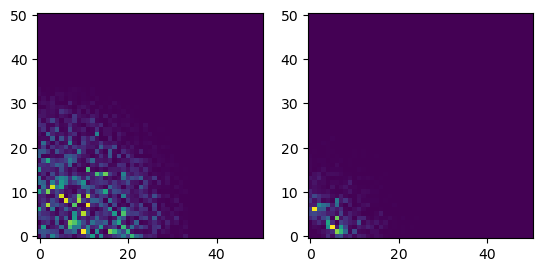

In [200]:
fig, ax = plt.subplots(1,2)
r=1
n1=2
n2=1200
ax[0].imshow(S_k2[r, n1], origin='lower')
ax[1].imshow(S_k2[r, n2], origin='lower')

In [201]:
S_q = np.zeros([len(runs), n_dump, len(q2)])
for r in runs-1:
    for qi in np.arange(len(q2)):
        for qx in np.arange(0, qi, 1):
            qy = np.int32(np.sqrt(qi**2-qx**2))
            S_q[:, :, qi] += S_k2[:, :, qx, qy]

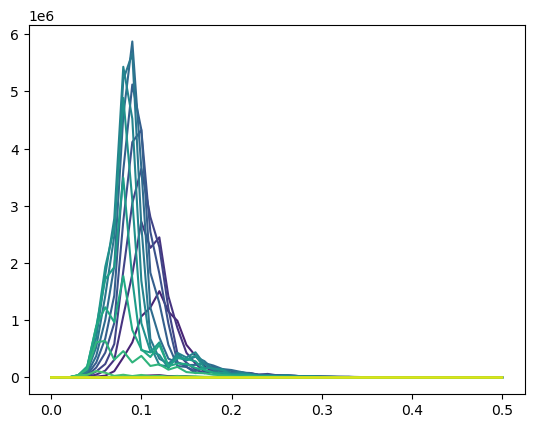

In [202]:
cmap=plt.get_cmap("viridis")
r=1
i=100
f=1999
d=100
for n in np.arange(i, f, d):
    plt.plot(q2, S_q[r, n], color=cmap(n/f))
plt.show()

Text(0, 0.5, '$q_{max}$')

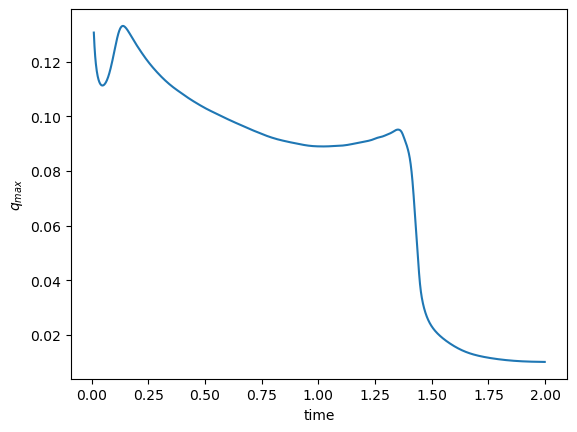

In [203]:
fS_q = S_q/np.sum(S_q, axis=2)[:, :, np.newaxis]
weighted_q = np.sum(q2*fS_q, axis=2)
max_q = q2[np.argmax(S_q, axis=2)]
#plt.plot(times[100:-1], max_q[:, 100:-1].T)
plt.plot(times[10:-1], np.mean(weighted_q[:, 10:-1], axis=0))
plt.xlabel('time')
plt.ylabel(r'$q_{max}$')
#plt.scatter(times[650:-1], weighted_q[650:-1])

/tmp/ipykernel_151800/315767703.py:3: RuntimeWarning: invalid value encountered in sqrt
  q_theory = np.sqrt(-(12*(rho_avg[:, i:f]**2) -(18*rho_avg[:, i:f])+4.5)/2)


Text(0, 0.5, '$<q S_q>$')

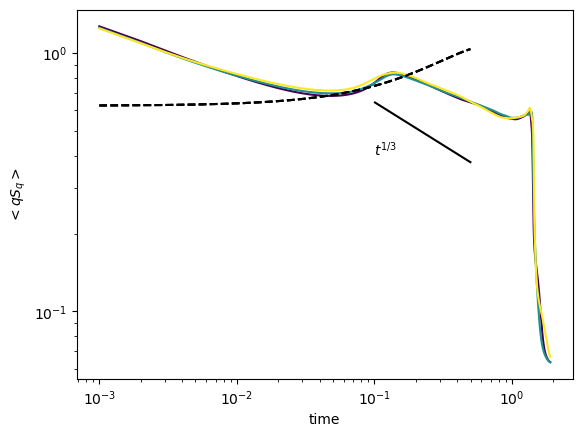

In [204]:
i=1
f=1900
q_theory = np.sqrt(-(12*(rho_avg[:, i:f]**2) -(18*rho_avg[:, i:f])+4.5)/2)
#plt.plot(times[i:f], max_q[:,i:f].T)
for r in runs-1:
    plt.plot(times[i:f], 2*np.pi*weighted_q[r,i:f], color=cmap(r/max(runs-1)))
    plt.plot(times[i:500], q_theory[r, i:500], color='k', linestyle='dashed')
plt.plot(times[i+100:500], 0.3*times[i+100:500]**(-1/3), color='k')
plt.text( 0.1, 0.4, r'$t^{1/3}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('time')
plt.ylabel(r'$<q S_q>$')
#plt.scatter(q_theory, max_q[i:f])

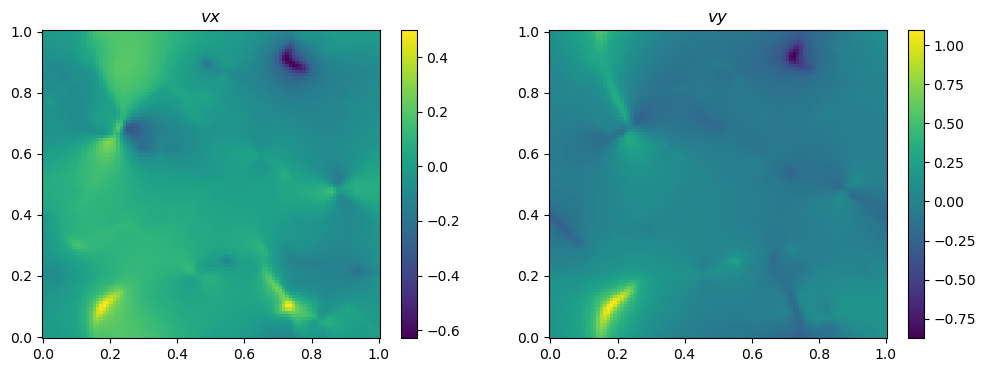

In [98]:
n=1999
vx = np.loadtxt(datadir+'vx.csv.{:d}'.format(n), delimiter=',')
vy = np.loadtxt(datadir+'vy.csv.{:d}'.format(n), delimiter=',')

fig, ax=plt.subplots(figsize=(12,4),ncols=2)
plot1 = [ax[0].pcolormesh(xv, yv, vx, cmap='viridis', vmin=np.min(vx), vmax=np.max(vx))]
plot2 = [ax[1].pcolormesh(xv, yv, vy, cmap='viridis', vmin=np.min(vy), vmax=np.max(vy))]

fig.colorbar(plot1[0], ax=ax[0])
fig.colorbar(plot2[0], ax=ax[1])
ax[0].set_title(r"$ vx $")
ax[1].set_title(r"$ vy $")
plt.show()

0.9566947375992108 0.06949848968218532


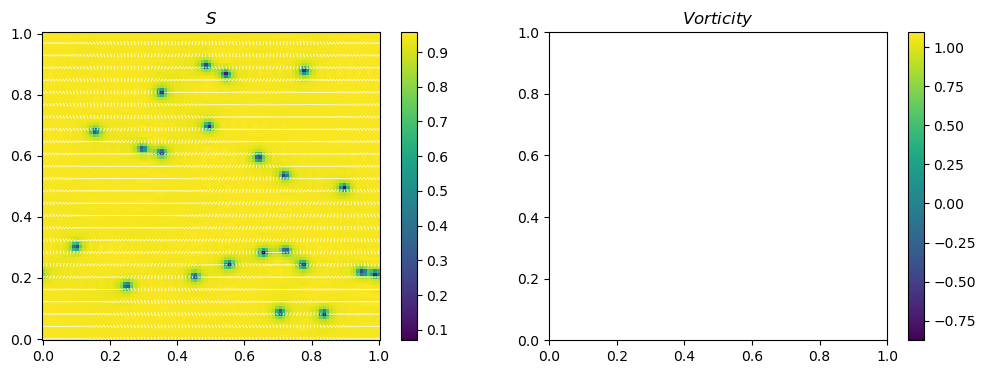

In [103]:
fig, ax=plt.subplots(figsize=(12,4),ncols=2)
#colors = ['#c1272d', '#eecc16','#008176','#0000a7']
#cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

n=20

Qxx = np.loadtxt(datadir+'Qxx.csv.{:d}'.format(n), delimiter=',')
Qxy = np.loadtxt(datadir+'Qxy.csv.{:d}'.format(n), delimiter=',')
#curldivQ = np.loadtxt(datadir+'curldivQ.csv.{:d}'.format(n), delimiter=',')
S = np.sqrt(Qxx**2+Qxy**2)
p_factor = 4
theta = np.arctan2(Qxy, Qxx)/2
Snx    = (S*np.cos(theta))
Sny    = (S*np.sin(theta))
print(np.max(S), np.min(S))

plot1 = [ax[0].pcolormesh(xv, yv, S, cmap='viridis', vmin=np.min(S), vmax=np.max(S)), ax[0].quiver(xv[::p_factor],yv[::p_factor],Snx[::p_factor],Sny[::p_factor], color='w', pivot='middle', headlength=0, headaxislength=0)]
#plot2 = [ax[1].pcolormesh(xv, yv, curldivQ, cmap='viridis', vmin=np.min(curldivQ), vmax=np.max(curldivQ)), ax[1].quiver(xv,yv,Snx,Sny, color='w', pivot='middle', headlength=0, headaxislength=0)]

fig.colorbar(plot1[0], ax=ax[0])
fig.colorbar(plot2[0], ax=ax[1])
ax[0].set_title(r"$ S $")
ax[1].set_title(r"$ Vorticity $")
plt.show()

0.06927470877411412


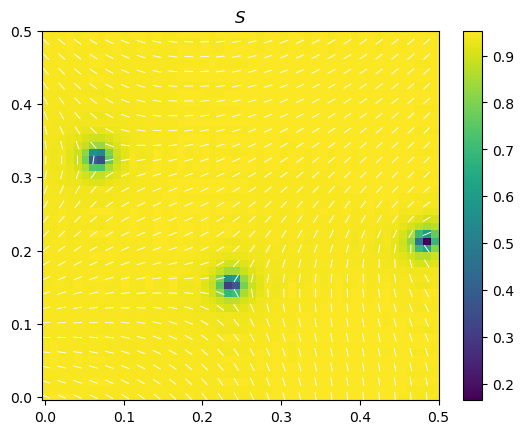

In [109]:
fig, ax=plt.subplots()
#colors = ['#c1272d', '#eecc16','#008176','#0000a7']
#cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

n=59


#charge = np.loadtxt(datadir+'curldivQ.csv.{:d}'.format(n), delimiter=',')
Qxx = np.loadtxt(datadir+'Qxx.csv.{:d}'.format(n), delimiter=',')
Qxy = np.loadtxt(datadir+'Qxy.csv.{:d}'.format(n), delimiter=',')
S = np.sqrt(Qxx**2+Qxy**2)
theta = np.arctan2(Qxy, Qxx)/2
nx    = np.cos(theta)
ny    = np.sin(theta)

#print(np.max(charge), np.min(charge))

p_factor = 2
#pcharge = pixelate(2*charge/S, p_factor)
#print(np.max(pcharge))
#p_half_defects = np.where((pcharge)>0.2)
#m_half_defects = np.where((-pcharge)>0.2)
#print(p_half_defects, m_half_defects)

print(np.mean(theta))

ix, fx, iy, fy = 0, 50, 0, 50
ctrf = [ax.pcolormesh(xv[ix:fx, iy:fy], yv[ix:fx, iy:fy], (S)[ix:fx, iy:fy], cmap='viridis', vmin=np.min(S), vmax=np.max(S))]
ax.quiver(xv[ix:fx:p_factor, iy:fy:p_factor],yv[ix:fx:p_factor, iy:fy:p_factor], nx[ix:fx:p_factor, iy:fy:p_factor], ny[ix:fx:p_factor, iy:fy:p_factor], color='w', pivot='middle', headlength=0, headaxislength=0)
#ax.scatter(p_half_defects[1]/mx, p_half_defects[0]/my, color='pink')
#ax.scatter(m_half_defects[1]/mx, m_half_defects[0]/my, color='red')
#ctrf = [ax.pcolormesh(xv, yv, rho[i], cmap=cmap1, vmin=np.min(rho), vmax=np.max(rho)), ax.quiver(xv,yv,nx[i],ny[i], color='w', headlength=0, headaxislength=0, width=0.006, pivot='middle')]
#ctrf = [ax.pcolormesh(xv, yv, rho[i]*v[i,:,:,1])]
plt.colorbar(ctrf[0])
plt.title(r"$ S $")
plt.show()

In [5]:
def pixelate(x, gridpoints):
    nx, ny = np.shape(x)
    xpad = np.pad(x, (gridpoints, gridpoints), 'wrap')
    ret = np.zeros(np.shape(x))
    for cx in np.arange(nx):
        for cy in np.arange(ny):
            ret[cx, cy] += np.average(xpad[cx:cx+1+2*gridpoints, cy:cy+1+2*gridpoints])
    return ret